### Step 1: Data Preprocessing

#### Load Metadata and Annotations


In [41]:
import pandas as pd

# Define file paths
metadata_file = '../dataset//development_scenes.csv'
annotations_file = '../dataset/development_scene_annotations.csv'

# Load the CSV files
metadata = pd.read_csv(metadata_file)
annotations = pd.read_csv(annotations_file)

print("Metadata:")
print(metadata.head())
print("\nAnnotations:")
print(annotations.head())


Metadata:
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132

Annotations:
                        filename         command     start       end
0         2_speech_true_Ofen_aus        Ofen aus  11.25230  12.07747
1         3_speech_true_Radio_an  Staubsauger an  21.48040  23.18083
2         4_speech_true_Alarm_an        Alarm an  14.45720  16.08301
3        9_speech_true_Radio_aus  Staubsauger an   3.67909   5.63126
4  11_speech_false_Fernseher_aus  Staubsauger an  10.57850  11.67886


#### Preprocess Audio Files (WAV) and Perform ICA


In [42]:
import os
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import numpy as np

# Define directories
scenes_dir = '../dataset/scenes/wav'  # Update this path

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    scaler = StandardScaler()
    audio = scaler.fit_transform(audio.reshape(-1, 1)).flatten()
    
    ica = FastICA(n_components=1, whiten='unit-variance')
    audio = ica.fit_transform(audio.reshape(-1, 1)).flatten()
    
    return audio, sr

# Function to segment audio based on annotations
def segment_audio(audio, sr, start, end):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return audio[start_sample:end_sample]

# Preprocess and segment all audio files
preprocessed_segments = []

for idx, row in annotations.iterrows():
    file_name = row['filename']
    command = row['command']
    start = row['start']
    end = row['end']
    
    file_path = os.path.join(scenes_dir, file_name + '.wav')
    
    try:
        audio, sr = load_and_preprocess_audio(file_path)
        segment = segment_audio(audio, sr, start, end)
        preprocessed_segments.append((file_name, command, segment, sr))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example: display the first segment
print(f"First segment: {preprocessed_segments[0]}")


First segment: ('2_speech_true_Ofen_aus', 'Ofen aus', array([0.08628684, 0.07286587, 0.07549172, ..., 0.42793807, 0.432898  ,
       0.45507178], dtype=float32), 16000)


### Step 2: Data Augmentation

#### Apply Data Augmentation


In [51]:
import librosa
import numpy as np

# Function to augment audio
def augment_audio(audio, sr):
    augmented = []
    # Original length
    original_length = len(audio)
    
    # Shift
    shift = int(sr * 0.5)  # shift by 0.5 seconds
    shifted_audio = np.roll(audio, shift)
    augmented.append(shifted_audio)
    
    # Stretch
    stretch = librosa.effects.time_stretch(audio, rate=0.8)
    if len(stretch) < original_length:
        # Pad with zeros if stretched audio is shorter
        stretch = np.pad(stretch, (0, original_length - len(stretch)), mode='constant')
    else:
        stretch = stretch[:original_length]  # ensure same length
    augmented.append(stretch)
    
    # Debug information
    for aug_audio in augmented:
        print(f"Original length: {original_length}, Augmented length: {len(aug_audio)}")
        if len(aug_audio) < 2048:
            print(f"Warning: Augmented segment length {len(aug_audio)} is shorter than n_fft=2048")
    
    return augmented

# Apply augmentation to all segments
augmented_segments = []
for file_name, command, segment, sr in preprocessed_segments:
    augmented = augment_audio(segment, sr)
    for aug in augmented:
        augmented_segments.append((file_name, command, aug, sr))

# Combine original and augmented data
all_segments = preprocessed_segments + augmented_segments


Original length: 13203, Augmented length: 13203
Original length: 13203, Augmented length: 13203
Original length: 27207, Augmented length: 27207
Original length: 27207, Augmented length: 27207
Original length: 26013, Augmented length: 26013
Original length: 26013, Augmented length: 26013
Original length: 31235, Augmented length: 31235
Original length: 31235, Augmented length: 31235
Original length: 17605, Augmented length: 17605
Original length: 17605, Augmented length: 17605
Original length: 29227, Augmented length: 29227
Original length: 29227, Augmented length: 29227
Original length: 18003, Augmented length: 18003
Original length: 18003, Augmented length: 18003
Original length: 16013, Augmented length: 16013
Original length: 16013, Augmented length: 16013
Original length: 26006, Augmented length: 26006
Original length: 26006, Augmented length: 26006
Original length: 23623, Augmented length: 23623
Original length: 23623, Augmented length: 23623
Original length: 23210, Augmented length

/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Original length: 17207, Augmented length: 17207
Original length: 17207, Augmented length: 17207
Original length: 22810, Augmented length: 22810
Original length: 22810, Augmented length: 22810
Original length: 17199, Augmented length: 17199
Original length: 17199, Augmented length: 17199
Original length: 15199, Augmented length: 15199
Original length: 15199, Augmented length: 15199
Original length: 25637, Augmented length: 25637
Original length: 25637, Augmented length: 25637
Original length: 20403, Augmented length: 20403
Original length: 20403, Augmented length: 20403
Original length: 18398, Augmented length: 18398
Original length: 18398, Augmented length: 18398
Original length: 22416, Augmented length: 22416
Original length: 22416, Augmented length: 22416
Original length: 18413, Augmented length: 18413
Original length: 18413, Augmented length: 18413
Original length: 16410, Augmented length: 16410
Original length: 16410, Augmented length: 16410
Original length: 28018, Augmented length

### Step 3: Feature Extraction

#### Extract Features with Padding/Truncation and Dynamic `n_fft`


In [52]:
# Function to extract features with dynamic n_fft
def extract_features(segment, sr, max_length):
    n_fft = min(2048, max(256, len(segment) // 2))  # Ensure n_fft is not larger than half the segment length and at least 256
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    print(f"Extracting features with n_fft={n_fft} for segment length={len(segment)}")
    hop_length = n_fft // 4  # Typical value for hop_length
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfccs_flat = mfccs.flatten()
    if len(mfccs_flat) < max_length:
        # Pad with zeros
        padded_mfccs = np.pad(mfccs_flat, (0, max_length - len(mfccs_flat)), mode='constant')
        return padded_mfccs
    else:
        # Truncate to max_length
        return mfccs_flat[:max_length]

# Determine the maximum length for padding/truncation
max_length = 0
for _, _, segment, sr in all_segments:
    n_fft = min(2048, max(256, len(segment) // 2))
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    hop_length = n_fft // 4
    features = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length).flatten()
    if len(features) > max_length:
        max_length = len(features)

# Extract features for all segments with padding/truncation
feature_data = []
for file_name, command, segment, sr in all_segments:
    features = extract_features(segment, sr, max_length)
    feature_data.append((file_name, command, features))

print(f"Feature extraction completed with max length: {max_length}")


Extracting features with n_fft=2048 for segment length=13203
Extracting features with n_fft=2048 for segment length=27207
Extracting features with n_fft=2048 for segment length=26013
Extracting features with n_fft=2048 for segment length=31235
Extracting features with n_fft=2048 for segment length=17605
Extracting features with n_fft=2048 for segment length=29227
Extracting features with n_fft=2048 for segment length=18003
Extracting features with n_fft=2048 for segment length=16013
Extracting features with n_fft=2048 for segment length=26006
Extracting features with n_fft=2048 for segment length=23623
Extracting features with n_fft=2048 for segment length=23210
Extracting features with n_fft=2048 for segment length=13211
Extracting features with n_fft=2048 for segment length=14011
Extracting features with n_fft=2048 for segment length=20823
Extracting features with n_fft=2048 for segment length=16793
Extracting features with n_fft=2048 for segment length=20811
Extracting features with

### Step 4: Model Training and Evaluation

#### Train `GradientBoostingClassifier` with Class Weights and Progress Bar


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np

# Prepare data for training
X = np.array([features for _, _, features in feature_data])
y = np.array([command for _, command, _ in feature_data])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Create sample weights
sample_weights = np.array([class_weight_dict[cls] for cls in y_train])

# Train a Gradient Boosting classifier with a progress bar and sample weights
n_estimators = 100
gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42, warm_start=True)

# Wrap the training loop with tqdm for the progress bar
for i in tqdm(range(1, n_estimators + 1), desc="Training Gradient Boosting Classifier"):
    gb.n_estimators = i
    gb.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate the classifier
y_pred = gb.predict(X_val)
print(classification_report(y_val, y_pred, zero_division=0))

# Plot confusion matrix
labels = np.unique(y_val)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_confusion_matrix(y_val, y_pred, labels, title='Confusion Matrix - Gradient Boosting')


Training Gradient Boosting Classifier:  18%|█▊        | 18/100 [01:49<08:19,  6.09s/it]

#### Train `RandomForestClassifier` with Class Weights


                 precision    recall  f1-score   support

       Alarm an       0.86      0.24      0.38        25
      Alarm aus       1.00      0.03      0.06        31
   Fernseher an       0.00      0.00      0.00        33
  Fernseher aus       1.00      0.04      0.08        24
     Heizung an       1.00      0.03      0.06        31
    Heizung aus       0.00      0.00      0.00        28
       Licht an       0.31      0.09      0.13        47
      Licht aus       0.41      0.23      0.29        40
     Lüftung an       0.00      0.00      0.00        21
    Lüftung aus       1.00      0.03      0.06        30
        Ofen an       0.50      0.05      0.09        21
       Ofen aus       1.00      0.12      0.21        25
       Radio an       1.00      0.05      0.10        38
      Radio aus       0.67      0.15      0.24        27
 Staubsauger an       0.33      0.98      0.49       191
Staubsauger aus       1.00      0.11      0.20        27

       accuracy              

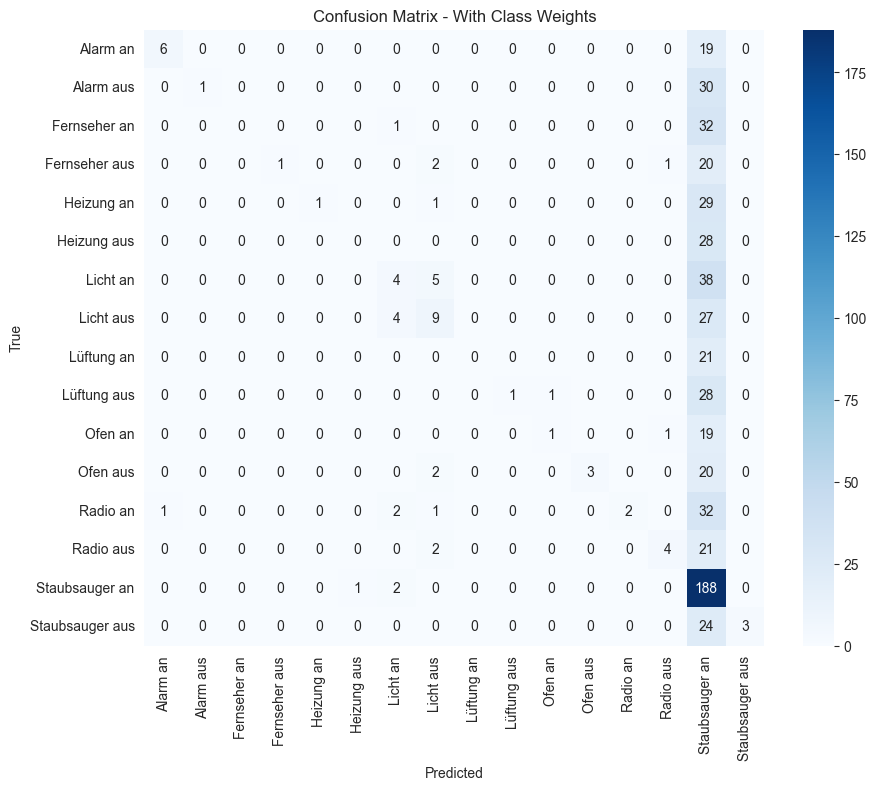

In [53]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf.fit(X_train, y_train)

# Evaluate the classifier
y_pred_weighted = rf.predict(X_val)
print(classification_report(y_val, y_pred_weighted, zero_division=0))

# Plot confusion matrix with class weights
plot_confusion_matrix(y_val, y_pred_weighted, labels, title='Confusion Matrix - With Class Weights')


### Step 5: Ensemble Classifiers


In [ ]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and Gradient Boosting
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate the ensemble classifier
y_pred_ensemble = ensemble.predict(X_val)
print(classification_report(y_val, y_pred_ensemble, zero_division=0))

# Plot confusion matrix
plot_confusion_matrix(y_val, y_pred_ensemble, labels, title='Confusion Matrix - Ensemble')


### Summary

We've consolidated the process into five clear steps:

1. **Data Preprocessing**: Load metadata and preprocess audio files with ICA.
2. **Data Augmentation**: Apply time-shifting and time-stretching to augment the audio data.
3. **Feature Extraction**: Extract MFCC features with appropriate padding/truncation and dynamic `n_fft`.
4. **Model Training and Evaluation**: Train `GradientBoostingClassifier` and `RandomForestClassifier`, handle class weights, and evaluate their performance.
5. **Ensemble Classifiers**: Combine predictions from multiple models to improve robustness.

Let's proceed with running these steps sequentially to ensure there are no errors, warnings, or obstacles. If you encounter any issues or need further adjustments, please let me know!